In [3]:
#import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import DataFrameWriter
import psycopg2
import os

ModuleNotFoundError: No module named 'psycopg2'

In [ ]:
 spark = SparkSession.builder.appName('Nuga Scheduler')\
        .config('spark.jars' , 'postgresql-42.7.3.jar'  )\
        .getOrCreate()

In [4]:
spark

In [5]:
# import dataset
df = spark.read.csv('nuga_bank_transactions.csv', header=True, inferSchema=True)
df.show()

+--------------------+------+----------------+-----------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------+-------------+--------+-----+---------+--------------------+--------------------+------+--------------+
|    Transaction_Date|Amount|Transaction_Type|    Customer_Name|    Customer_Address|       Customer_City|Customer_State|    Customer_Country|             Company|           Job_Title|               Email|       Phone_Number| Credit_Card_Number|                IBAN|Currency_Code|Random_Number|Category|Group|Is_Active|        Last_Updated|         Description|Gender|Marital_Status|
+--------------------+------+----------------+-----------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------

Data Cleaning 

In [6]:
#check null values
for i in df.columns:
    null = df.filter(df[i].isNull()).count()
    print(i,' NULLS = ',null)

Transaction_Date  NULLS =  0
Amount  NULLS =  0
Transaction_Type  NULLS =  0
Customer_Name  NULLS =  100425
Customer_Address  NULLS =  100087
Customer_City  NULLS =  100034
Customer_State  NULLS =  100009
Customer_Country  NULLS =  100672
Company  NULLS =  100295
Job_Title  NULLS =  99924
Email  NULLS =  100043
Phone_Number  NULLS =  100524
Credit_Card_Number  NULLS =  100085
IBAN  NULLS =  100300
Currency_Code  NULLS =  99342
Random_Number  NULLS =  99913
Category  NULLS =  100332
Group  NULLS =  100209
Is_Active  NULLS =  100259
Last_Updated  NULLS =  100321
Description  NULLS =  100403
Gender  NULLS =  99767
Marital_Status  NULLS =  99904


In [7]:
df.printSchema()

root
 |-- Transaction_Date: timestamp (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Customer_Address: string (nullable = true)
 |-- Customer_City: string (nullable = true)
 |-- Customer_State: string (nullable = true)
 |-- Customer_Country: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Phone_Number: string (nullable = true)
 |-- Credit_Card_Number: long (nullable = true)
 |-- IBAN: string (nullable = true)
 |-- Currency_Code: string (nullable = true)
 |-- Random_Number: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- Group: string (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Last_Updated: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Marital_Status: string (nullable = true)

In [8]:
#column Last_Updated has timestamp datatype so we will drop records of null values
df = df.na.drop(subset='Last_Updated')

In [9]:
#fill null values
for i in df.columns:
    data_types = dict(df.dtypes)[i]
    if data_types == 'string':
        df = df.fillna({i:'unknow'})
    elif data_types == 'double':
        df = df.fillna({i : 0.0})
    else:
        df = df.fillna({i : 0})

In [10]:
#check for null values
for i in df.columns:
    null = df.filter(df[i].isNull()).count()
    print(i,' Nulls = ',null)

Transaction_Date  Nulls =  0
Amount  Nulls =  0
Transaction_Type  Nulls =  0
Customer_Name  Nulls =  0
Customer_Address  Nulls =  0
Customer_City  Nulls =  0
Customer_State  Nulls =  0
Customer_Country  Nulls =  0
Company  Nulls =  0
Job_Title  Nulls =  0
Email  Nulls =  0
Phone_Number  Nulls =  0
Credit_Card_Number  Nulls =  0
IBAN  Nulls =  0
Currency_Code  Nulls =  0
Random_Number  Nulls =  0
Category  Nulls =  0
Group  Nulls =  0
Is_Active  Nulls =  0
Last_Updated  Nulls =  0
Description  Nulls =  0
Gender  Nulls =  0
Marital_Status  Nulls =  0


Data Modeling

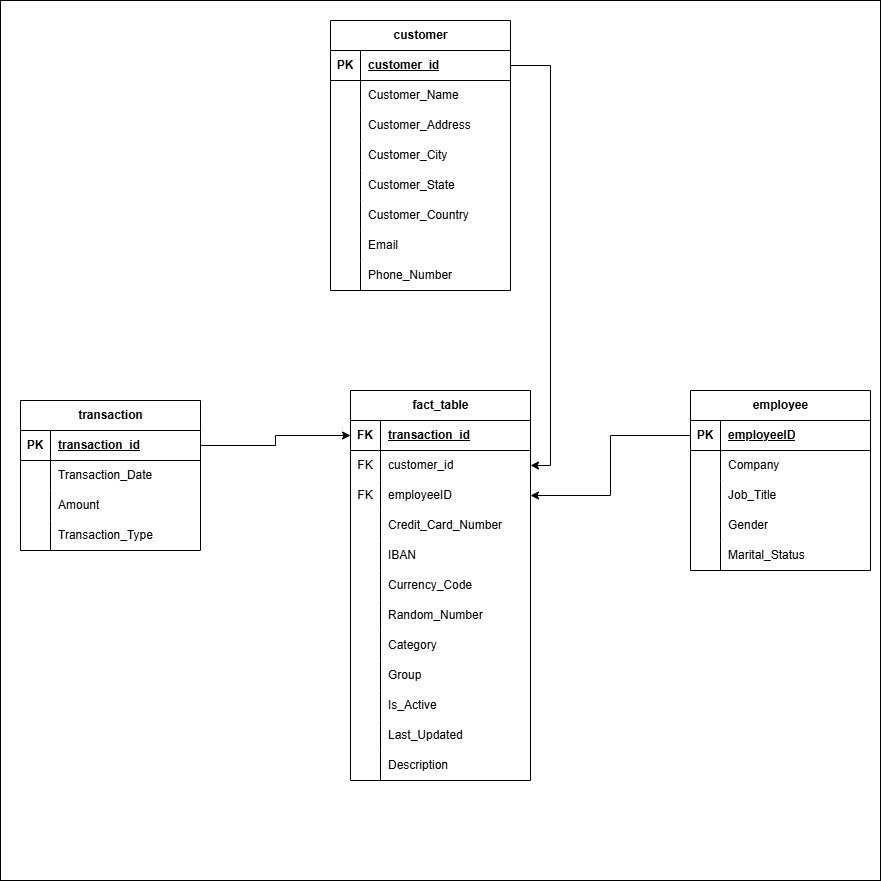

Data Transformation

In [11]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [12]:
#create table transaction
transaction = df.select('Transaction_Date','Amount','Transaction_Type')

#create column transaction_id
w = Window.orderBy(f.lit(1))
transaction = transaction.withColumn('transaction_id', row_number().over(w))\
              .select('transaction_id','Transaction_Date','Amount','Transaction_Type')

transaction.show(5)

+--------------+--------------------+------+----------------+
|transaction_id|    Transaction_Date|Amount|Transaction_Type|
+--------------+--------------------+------+----------------+
|             1|2024-03-23 15:38:...| 34.76|      Withdrawal|
|             2|2024-04-22 19:15:...|163.92|      Withdrawal|
|             3|2024-04-12 19:46:...|386.32|      Withdrawal|
|             4|2024-04-17 15:29:...|407.15|         Deposit|
|             5|2024-02-10 01:51:...|161.31|         Deposit|
+--------------+--------------------+------+----------------+
only showing top 5 rows



In [13]:
# create table customer
customer = df.select('Customer_Name',
 'Customer_Address',
 'Customer_City',
 'Customer_State',
 'Customer_Country','Email',
 'Phone_Number')

w = Window.orderBy(f.lit(1))

customer = customer.withColumn('customer_id', row_number().over(w))\
            .select('customer_id','Customer_Name','Customer_Address','Customer_City','Customer_State', 'Customer_Country','Email','Phone_Number')

customer.show(5)

+-----------+--------------+--------------------+------------------+--------------+--------------------+--------------------+-------------------+
|customer_id| Customer_Name|    Customer_Address|     Customer_City|Customer_State|    Customer_Country|               Email|       Phone_Number|
+-----------+--------------+--------------------+------------------+--------------+--------------------+--------------------+-------------------+
|          1|    James Neal|54912 Holmes Lodg...| West Keithborough|       Florida|                Togo|              unknow|  493.720.6609x7545|
|          2|   Thomas Long| 1133 Collin Passage|        Joshuabury|   Connecticut|Lao People's Demo...|michellelynch@exa...|      (497)554-3317|
|          3|Ashley Shelton|5297 Johnson Port...|       North Maria|    New Jersey|              Bhutan| ljordan@example.org|      (534)769-3072|
|          4| James Rosario|56955 Moore Glens...|North Michellefurt|    New Mexico|             Iceland|parkerjames@examp...

In [14]:
#create table employee
employee = df.select('Company','Job_Title','Gender','Marital_Status')

w= Window.orderBy(f.lit(1))
employee = employee.withColumn('employee_id', row_number().over(w))\
           .select('employee_id','Company','Job_Title','Gender','Marital_Status')

employee.show(5)

+-----------+--------------------+--------------------+------+--------------+
|employee_id|             Company|           Job_Title|Gender|Marital_Status|
+-----------+--------------------+--------------------+------+--------------+
|          1|Benson, Johnson a...|              unknow| Other|      Divorced|
|          2|              unknow|   Food technologist|Female|       Married|
|          3|       Jones-Mueller|Database administ...| Other|        unknow|
|          4|       Vargas-Harris|Horticultural the...|unknow|        unknow|
|          5|Richardson, Gonza...|   Minerals surveyor|Female|       Married|
+-----------+--------------------+--------------------+------+--------------+
only showing top 5 rows



In [15]:
#create fact_table
fact = df.join(transaction, on=['Transaction_Date','Amount','Transaction_Type'], how='left')\
         .join(customer,on=['Customer_Name','Customer_Address','Customer_City','Customer_State', 'Customer_Country','Email','Phone_Number'],how='left')\
         .join(employee,on=['Company','Job_Title','Gender','Marital_Status'],how='left')\
         .select('transaction_id','customer_id','employee_id','Credit_Card_Number','IBAN','Currency_Code','Random_Number','Category','Group','Is_Active','Last_Updated','Description')

fact.show()

+--------------+-----------+-----------+-------------------+--------------------+-------------+-------------+--------+-----+---------+--------------------+--------------------+
|transaction_id|customer_id|employee_id| Credit_Card_Number|                IBAN|Currency_Code|Random_Number|Category|Group|Is_Active|        Last_Updated|         Description|
+--------------+-----------+-----------+-------------------+--------------------+-------------+-------------+--------+-----+---------+--------------------+--------------------+
|        835961|     436482|     835961|      4511208969578|GB04TVBU672029194...|          NAD|       6450.0|       B|    X|      Yes|2023-02-21 21:19:...|Support use detai...|
|         76005|     152009|      76005|   4812381332621824|GB53ZMWN860991284...|       unknow|       7790.0|       A|    Z|      Yes|2020-11-13 06:08:...|Rather decision t...|
|        227982|     455963|     227982|4028728529164460418|GB36NHIK654260063...|          ANG|       6335.0|      

Data Loading

In [17]:
import psycopg2

In [18]:
# Define database connection parameters including the database name
db_params = {
    'username':'postgres',
    'password':'ahly9667',
    'host':'localhost',
    'port':'5432',
    'database':'nuga_bank_scheduled'
}

default_db_url =f"postgresql://{db_params['username']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/postgres"

#create database
try:
    # open the connection
    conn = psycopg2.connect(default_db_url)
    conn.autocommit = True
    cur = conn.cursor()

#check if the database is already existed
    cur.execute(f"select 1 from pg_catalog.pg_database where datname='{db_params['database']}'")
    exists = cur.fetchone()
    if not exists:
        # Create the database
        cur.execute(f"create database {db_params['database']}")
        print(f"Database {db_params['database']} created successfully")

    else:
        print(f"Database {db_params['database']} already existed")

    # Close the cnnection
    cur.close()
    conn.close()
except exception as e :
    print(f"an error {e} occurred")

Database nuga_bank_scheduled created successfully


In [19]:
# Connect to the new created database alayta_bank
def db_connected():
    connection = psycopg2.connect(user = 'postgres', 
                                  host= 'localhost',
                                  password = 'ahly9667',
                                  port = 5432,
                                  database ='nuga_bank_scheduled')

    return connection

conn = db_connected()
print(f"Database {db_params['database']} connected successfully")

Database nuga_bank_scheduled connected successfully


In [20]:
#create a function to create related tables of schema
def create_table():
    conn = db_connected()
    cursor= conn.cursor()
    query = """
                 drop table if exists transaction;
                 drop table if exists customer;
                 drop table if exists employss;
                 drop table if exists fact_table;

                 create table transaction(
                 transaction_id bigint primary key,
                 Transaction_Date date,
                 Amount float,
                 Transaction_Type varchar(10000));

                 create table customer(
                 customer_id bigint primary key,
                 Customer_Name varchar(10000),
                 Customer_Address varchar(10000) ,
                 Customer_City varchar(10000),
                 Customer_State varchar(10000),
                 Customer_Country varchar(10000),
                 Email varchar(10000),
                 Phone_Number varchar(10000));

                 create table employee(
                 employee_id bigint primary key,
                 Company varchar(10000),
                 Job_Title varchar(10000),
                 Gender varchar(10000),
                 Marital_Status varchar(10000));

                 create table fact_table(
                 transaction_id bigint,
                 customer_id bigint,
                 employee_id bigint,
                 Credit_Card_Number bigint,
                 IBAN varchar(10000),
                 Currency_Code varchar(10000),
                 Random_Number float,
                 Category varchar(10000),
                 "Group" varchar(10000),
                 Is_Active varchar(10000),
                 Last_Updated date,
                 Description varchar(10000),
                 foreign key (transaction_id) references transaction(transaction_id),
                 foreign key (customer_id) references customer(customer_id) ,
                 foreign key (employee_id ) references employee(employee_id ) ) ;
                """
    cursor.execute(query)
    conn.commit()
    cursor.close()
    conn.close()

create_table()
print('Tables created successfully')


Tables created successfully


In [23]:
#load data into tables
my_url = "jdbc:postgresql://localhost:5432/nuga_bank_scheduled"
my_properties = {'user' : 'postgre',
              'password' : 'ahly9667',
              'driver' : 'org.postgresql.Driver'}

customer.write.jdbc( url= my_url , table = 'customer' , mode ='append' ,properties= my_properties)
transaction.write.jdbc( url= my_url , table = 'transaction' , mode ='append' ,properties= my_properties)
employee.write.jdbc( url= my_url , table = 'employee' , mode ='append' ,properties= my_properties)
fact.write.jdbc( url= my_url , table = 'fact_table' , mode ='append' ,properties= my_properties)

print('Records added successfully to tables of database')

Py4JJavaError: An error occurred while calling o378.jdbc.
: org.postgresql.util.PSQLException: FATAL: password authentication failed for user "postgre"
	at org.postgresql.core.v3.ConnectionFactoryImpl.doAuthentication(ConnectionFactoryImpl.java:711)
	at org.postgresql.core.v3.ConnectionFactoryImpl.tryConnect(ConnectionFactoryImpl.java:213)
	at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl(ConnectionFactoryImpl.java:268)
	at org.postgresql.core.ConnectionFactory.openConnection(ConnectionFactory.java:54)
	at org.postgresql.jdbc.PgConnection.<init>(PgConnection.java:273)
	at org.postgresql.Driver.makeConnection(Driver.java:446)
	at org.postgresql.Driver.connect(Driver.java:298)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.BasicConnectionProvider.getConnection(BasicConnectionProvider.scala:49)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.ConnectionProviderBase.create(ConnectionProvider.scala:102)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1(JdbcDialects.scala:160)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1$adapted(JdbcDialects.scala:156)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:50)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:48)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:251)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:766)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
